In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
#import numdifftools as nd
import pandas as pd
#import pymc3 as pm

from tqdm import tqdm
from sklearn import preprocessing
from numpy.linalg import multi_dot
import scipy
from scipy import stats
from scipy.stats import invgamma
from scipy.special import gamma
from scipy.special import digamma
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde

In [2]:
from numba import vectorize, float64, guvectorize, jit

## LOAD DATASET

In [3]:
# GENERATE DATA FROM STABLE DISTRI
@jit(nopython=True)
def alpha_stable(alpha, beta, gamma, delta, dataset_size, num_datasets):
    V = np.pi / 2 * (2 * np.random.rand(num_datasets, dataset_size) - 1)
    W = - np.log(np.random.rand(num_datasets, dataset_size))
    #r = np.zeros(n)

    if alpha != 1:
        const = beta * np.tan(np.pi * alpha / 2)
        b = math.atan(const)
        s = (1 + const * const)**(1 / (2 * alpha))
        r = s * np.sin(alpha * V + b) / ((np.cos(V)) ** (1/alpha)) * (( np.cos( (1-alpha) * V - b ) / W )**((1-alpha)/alpha))
        r = gamma * r + delta
    else:
        piover2 = np.pi / 2
        sclshftV = piover2 + beta * V
        r = 1/piover2 * (sclshftV * np.tan(V) - beta * np.log( (piover2 * W * np.cos(V) ) / sclshftV ))
        r = gamma * r + (2 / np.pi) * beta * gamma * np.log(gamma) + delta
    return r

actual_data = alpha_stable(1.5, 0.5, 1, 0, 200, 10)
actual_data

array([[ 0.51451425, -0.43932278,  3.48676224, ..., -0.72353167,
         0.91386384, -1.28181598],
       [-0.01053975, -0.80678068,  0.33794296, ..., -1.04946818,
         0.05861048,  1.15313899],
       [ 0.55641193,  1.00840879, -0.66418892, ..., -0.95514308,
        -0.65104305, -0.59982324],
       ...,
       [ 0.47192836, -0.8795956 , -2.29406092, ..., -0.27438009,
         0.72553718, -1.97981167],
       [-2.06193105, -1.51027888, -0.04003056, ...,  0.338444  ,
         0.83516763,  0.96650547],
       [ 0.8366909 , -4.09077651,  2.32369557, ..., -0.69212775,
        -0.90058559, -1.44053384]])

In [4]:
# CALCULATE SUMMARY STATS
@jit
def alpha_stable_ss(data: np.ndarray) -> np.ndarray:
  # Compute quantile statistics
  v_stability = (np.percentile(data, 95) - np.percentile(data, 5)) / (np.percentile(data, 75) - np.percentile(data, 25))
  v_skewness = (np.percentile(data, 95) + np.percentile(data, 5) - 2 * np.percentile(data, 50)) / (np.percentile(data, 95) - np.percentile(data, 5))
  v_scale = (np.percentile(data, 75) - np.percentile(data, 25)) / 1
  v_loc = np.mean(data)

  # Define interpolation matrices (see [1])
  tv_stability = np.array([2.439, 2.5, 2.6, 2.7, 2.8, 3.0, 3.2, 3.5, 4.0, 5.0, 6.0, 8.0, 10.0, 15.0, 25.0])
  tv_skewness = np.array([0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0])
  t_stability = np.array([2.0, 1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5])
  t_skewness = np.array([0.0, 0.25, 0.5, 0.75, 1.0])

  psi1 = np.array([[2.000, 2.000, 2.000, 2.000, 2.000, 2.000, 2.000],
    [1.916, 1.924, 1.924, 1.924, 1.924, 1.924, 1.924],
    [1.808, 1.813, 1.829, 1.829, 1.829, 1.829, 1.829],
    [1.729, 1.730, 1.737, 1.745, 1.745, 1.745, 1.745],
    [1.664, 1.663, 1.663, 1.668, 1.676, 1.676, 1.676],
    [1.563, 1.560, 1.553, 1.548, 1.547, 1.547, 1.547],
    [1.484, 1.480, 1.471, 1.460, 1.448, 1.438, 1.438],
    [1.391, 1.386, 1.378, 1.364, 1.337, 1.318, 1.318],
    [1.279, 1.273, 1.266, 1.250, 1.210, 1.184, 1.150],
    [1.128, 1.121, 1.114, 1.101, 1.067, 1.027, 0.973],
    [1.029, 1.021, 1.014, 1.004, 0.974, 0.935, 0.874],
    [0.896, 0.892, 0.887, 0.883, 0.855, 0.823, 0.769],
    [0.818, 0.812, 0.806, 0.801, 0.780, 0.756, 0.691],
    [0.698, 0.695, 0.692, 0.689, 0.676, 0.656, 0.595],
    [0.593, 0.590, 0.588, 0.586, 0.579, 0.563, 0.513]])

  psi2 = np.array([[0.000, 2.160, 1.000, 1.000, 1.000, 1.000, 1.000],
    [0.000, 1.592, 3.390, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.759, 1.800, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.482, 1.048, 1.694, 1.000, 1.000, 1.000],
    [0.000, 0.360, 0.760, 1.232, 2.229, 1.000, 1.000],
    [0.000, 0.253, 0.518, 0.823, 1.575, 1.000, 1.000],
    [0.000, 0.203, 0.410, 0.632, 1.244, 1.906, 1.000],
    [0.000, 0.165, 0.332, 0.499, 0.943, 1.560, 1.000],
    [0.000, 0.136, 0.271, 0.404, 0.689, 1.230, 2.195],
    [0.000, 0.109, 0.216, 0.323, 0.539, 0.827, 1.917],
    [0.000, 0.096, 0.190, 0.284, 0.472, 0.693, 1.759],
    [0.000, 0.082, 0.163, 0.243, 0.412, 0.601, 1.596],
    [0.000, 0.074, 0.147, 0.220, 0.377, 0.546, 1.482],
    [0.000, 0.064, 0.128, 0.191, 0.330, 0.478, 1.362],
    [0.000, 0.056, 0.112, 0.167, 0.285, 0.428, 1.274]])

  psi3 = np.array([[1.908, 1.908, 1.908, 1.908, 1.908],
    [1.914, 1.915, 1.916, 1.918, 1.921],
    [1.921, 1.922, 1.927, 1.936, 1.947],
    [1.927, 1.930, 1.943, 1.961, 1.987],
    [1.933, 1.940, 1.962, 1.997, 2.043],
    [1.939, 1.952, 1.988, 2.045, 2.116],
    [1.946, 1.967, 2.022, 2.106, 2.211],
    [1.955, 1.984, 2.067, 2.188, 2.333],
    [1.965, 2.007, 2.125, 2.294, 2.491],
    [1.980, 2.040, 2.205, 2.435, 2.696],
    [2.000, 2.085, 2.311, 2.624, 2.973],
    [2.040, 2.149, 2.461, 2.886, 3.356],
    [2.098, 2.244, 2.676, 3.265, 3.912],
    [2.189, 2.392, 3.004, 3.844, 4.775],
    [2.337, 2.635, 3.542, 4.808, 6.247],
    [2.588, 3.073, 4.534, 6.636, 9.144]])


  psi4 = np.array([[0.0,    0.0,    0.0,    0.0,  0.0],  
    [0.0, -0.017, -0.032, -0.049, -0.064],
    [0.0, -0.030, -0.061, -0.092, -0.123],
    [0.0, -0.043, -0.088, -0.132, -0.179],
    [0.0, -0.056, -0.111, -0.170, -0.232],
    [0.0, -0.066, -0.134, -0.206, -0.283],
    [0.0, -0.075, -0.154, -0.241, -0.335],
    [0.0, -0.084, -0.173, -0.276, -0.390],
    [0.0, -0.090, -0.192, -0.310, -0.447],
    [0.0, -0.095, -0.208, -0.346, -0.508],
    [0.0, -0.098, -0.223, -0.383, -0.576],
    [0.0, -0.099, -0.237, -0.424, -0.652],
    [0.0, -0.096, -0.250, -0.469, -0.742],
    [0.0, -0.089, -0.262, -0.520, -0.853],
    [0.0, -0.078, -0.272, -0.581, -0.997],
    [0.0, -0.061, -0.279, -0.659, -1.198]])

  tv_stability_i1 = max(np.append(0, np.argwhere(tv_stability <= v_stability)))
  tv_stability_i2 = min(np.append(14, np.argwhere(tv_stability >= v_stability)))
  tv_skewness_i1 = max(np.append(0, np.argwhere(tv_skewness <= abs(v_skewness))))
  tv_skewness_i2 = min(np.append(6, np.argwhere(tv_skewness >= abs(v_skewness))))
  dist_stability = tv_stability[tv_stability_i2] - tv_stability[tv_stability_i1]
  if dist_stability != 0:
    dist_stability = (v_stability - tv_stability[tv_stability_i1]) / dist_stability

  dist_skewness = tv_skewness[tv_skewness_i2] - tv_skewness[tv_skewness_i1]
  if dist_skewness != 0:
    dist_skewness = (abs(v_skewness) - tv_skewness[tv_skewness_i1]) / dist_skewness

  psi1b1 = dist_stability*psi1[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i1]
  psi1b2 = dist_stability*psi1[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i2]
  alpha = dist_skewness*psi1b2+(1-dist_skewness)*psi1b1
  psi2b1 = dist_stability*psi2[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i1]
  psi2b2 = dist_stability*psi2[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i2]
  beta = np.sign(v_skewness)*(dist_skewness*psi2b2+(1-dist_skewness)*psi2b1)
  t_stability_i1 = max(np.append(0, np.argwhere(t_stability >= alpha)))
  t_stability_i2 = min(np.append(15, np.argwhere(t_stability <= alpha)))
  t_skewness_i1 = max(np.append(0, np.argwhere(t_skewness <= abs(beta))))
  t_skewness_i2 = min(np.append(4, np.argwhere(t_skewness >= abs(beta))))

  dist_stability = t_stability[t_stability_i2] - t_stability[t_stability_i1]
  if dist_stability != 0:
    dist_stability = (alpha - t_stability[t_stability_i1]) / dist_stability

  dist_skewness = t_skewness[t_skewness_i2] - t_skewness[t_skewness_i1]
  if dist_skewness != 0:
    dist_skewness = (abs(beta) - t_skewness[t_skewness_i1]) / dist_skewness

  psi3b1 = dist_stability*psi3[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i1]
  psi3b2 = dist_stability*psi3[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i2]
  sigma = v_scale/(dist_skewness*psi3b2+(1-dist_skewness)*psi3b1)
  psi4b1 = dist_stability*psi4[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i1]
  psi4b2 = dist_stability*psi4[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i2]
  zeta = np.sign(beta)*sigma*(dist_skewness*psi4b2+(1-dist_skewness)*psi4b1) + np.percentile(data, 50)

  if abs(alpha-1) < 0.05:
    mu = zeta
  else:
    mu = zeta - beta * sigma * math.tan(0.5 * math.pi *alpha)

  return np.array([alpha, beta, sigma, mu]) #stability, skewness, scale, loc

# actual_summary_statistics = alpha_stable_ss(actual_data)
# actual_summary_statistics

In [5]:
@jit
def summary_statistics(theta, n_samples, n_datasets):
    datasets = alpha_stable(theta[0], theta[1], theta[2], theta[3], n_samples, n_datasets)
    n_summary_statistics = np.array([alpha_stable_ss(datasets[i,:]) for i in range(n_datasets)])
    sample_mean = np.mean(n_summary_statistics, axis = 0)
    sample_variance = np.cov(np.array(n_summary_statistics).T)
    return sample_mean, sample_variance

In [6]:
actual_summary_statistics = alpha_stable_ss(actual_data)
actual_summary_statistics

array([ 1.55499824,  0.54144191,  0.9998782 , -0.02837829])

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [7]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 100 # number of datasets
        self.num_coeffs = np.shape(actual_summary_statistics)[0] # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def summary_statistics(self, theta):
        sample_mean, sample_variance = summary_statistics(theta, 200, self.num_datasets)
        return sample_mean, sample_variance

    def prior(self, theta): 
        log_prior = multivariate_normal.logpdf(theta, cov= 100 * np.identity(self.num_coeffs))
        
        return log_prior

    def unbiased_log_likelihood(self, theta):
        sample_mean = self.summary_statistics(theta)[0]
        sample_variance = self.summary_statistics(theta)[1]
        diff_mean_s = self.actual_summary_statistics - sample_mean
        part1 = diff_mean_s.T @ np.linalg.inv(sample_variance) @ diff_mean_s
        u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - (self.num_datasets - self.num_coeffs - 2) / (2 * (self.num_datasets-1)) * part1
        return u_est_log_likelihood

    def log_q(self, theta, mu, l):
        log_q = multivariate_normal.logpdf(theta, mean = mu, cov= np.linalg.inv(l @ l.T))
        return log_q

    def gradient_log_q(self, theta, mu, l): #indep theta
        gradient_log_q_mu = np.matmul(np.matmul(l, l.T), (theta - mu))
        gradient_log_q_l = (np.diag(1 / np.diag(l)) - np.matmul(((np.reshape(theta - mu, (self.num_coeffs,1))) * theta - mu), l)).T[np.triu_indices(self.num_coeffs)] #use * because matmul gives scalar 
        gradient_log_q = np.array([gradient_log_q_mu, gradient_log_q_l], dtype=object)
        return gradient_log_q

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        #mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        mu_0 = np.array([0] * self.num_coeffs)
        l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                # List of gradients
                Gradient_lb_init = []
                lb_0 = []
                theta_0_samples = multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)
                for s in tqdm(range(self.samples)):
                    # True params have been reparam into epsilon
                    theta_tilde_0 = theta_0_samples[s]
                    alpha_0 = (2 * np.exp(theta_tilde_0[0]) + 1.1) / (1 + np.exp(theta_tilde_0[0]))
                    beta_0 = (np.exp(theta_tilde_0[1]) - 1) / (np.exp(theta_tilde_0[1]) + 1)
                    gamma_0 = np.exp(theta_tilde_0[2])
                    delta_0 = theta_tilde_0[3]
                    theta_0 = np.array([alpha_0, beta_0, gamma_0, delta_0])
                    
                    # Find gradient of LB
                    h_lambda_init = self.prior(theta_tilde_0) + self.unbiased_log_likelihood(theta_0) - self.log_q(theta_tilde_0, mu_0, l_0)
                    gradient_lb_init = self.gradient_log_q(theta_tilde_0, mu_0, l_0) * (h_lambda_init)
                    Gradient_lb_init.append(gradient_lb_init)
                    # Calculate control variates
                    flattened_gradient_log_q = np.concatenate((self.gradient_log_q(theta_tilde_0, mu_0, l_0)[0], self.gradient_log_q(theta_tilde_0, mu_0, l_0)[1]), axis = None)
                    Flattened_gradient_log_q.append(flattened_gradient_log_q)
                    flattened_gradient_lb = np.concatenate((gradient_lb_init[0], gradient_lb_init[1]), axis = None)
                    Flattened_gradient_lb.append(flattened_gradient_lb)
                    # Calculate lower bound
                    lb_0.append(h_lambda_init)
                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)
                for s in range(self.samples):
                    theta_tilde_q = theta_q_samples[s]
                    # Calculate theta from mu, l (lambda)
                    alpha_q = (2 * np.exp(theta_tilde_q[0]) + 1.1) / (1 + np.exp(theta_tilde_q[0]))
                    beta_q = (np.exp(theta_tilde_q[1]) - 1) / (np.exp(theta_tilde_q[1]) + 1)
                    gamma_q = np.exp(theta_tilde_q[2])
                    delta_q = theta_tilde_q[3]
                    theta_q = np.array([alpha_q, beta_q, gamma_q, delta_q])
                    
                    # Find gradient of LB
                    h_lambda = self.prior(theta_tilde_q) + self.unbiased_log_likelihood(theta_q) - self.log_q(theta_tilde_q, mu_q, l_q)
                    # Find gradient of LB
                    gradient_lb = self.gradient_log_q(theta_tilde_q, mu_q, l_q) * (h_lambda - c)

                    Gradient_lb.append(gradient_lb)
                    # Calculate control variates
                    Flattened_gradient_log_q[s] = np.concatenate((self.gradient_log_q(theta_tilde_q, mu_q, l_q)[0], self.gradient_log_q(theta_tilde_q, mu_q, l_q)[1]), axis = None)
                    Flattened_gradient_lb[s] = np.concatenate((gradient_lb[0], gradient_lb[1]), axis = None)
                    # Calc lower bound estimate
                    lb_t.append(h_lambda)
                # Update control variates
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

## RUN VB AND PRINT OUT VARIATIONAL PARAMS

In [8]:
# Set hyperparameters
stop = 5000

In [9]:
vb = GVB(200, actual_summary_statistics, 0.001, 2500, 100, 0.9, 0.9, 50, 50)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 0/5000 [00:00<?, ?it/s]/tmp/ipykernel_16562/4237580040.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "summary_statistics" failed type inference due to: No implementation of function Function(<built-in function setitem>) found for signature:
 
 >>> setitem(array(undefined, 1d, C), int64, array(float64, 1d, C))
 
There are 16 candidate implementations:
  - Of which 16 did not match due to:
  Overload of function 'setitem': File: <numerous>: Line N/A.
    With argument(s): '(array(undefined, 1d, C), int64, array(float64, 1d, C))':
   No match.

During: typing of setitem at /tmp/ipykernel_16562/4237580040.py (4)

File "../../tmp/ipykernel_16562/4237580040.py", line 4:
<source missing, REPL/exec in use?>

  @jit
/opt/conda/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "summary_statistics" was compiled in object mode without forceobj=True.

File "../../tmp/ipykernel_16562/

LB -11.784016478121492


  0%|          | 2/5000 [00:15<10:07:40,  7.30s/it]

LB -11.741605998950629


  0%|          | 3/5000 [00:20<8:16:53,  5.97s/it] 

LB -11.903346489308896


  0%|          | 4/5000 [00:24<7:28:41,  5.39s/it]

LB -11.854321474115846


  0%|          | 5/5000 [00:28<6:50:03,  4.93s/it]

LB -11.831505109117302


  0%|          | 6/5000 [00:33<6:37:05,  4.77s/it]

LB -11.787934291044197


  0%|          | 7/5000 [00:38<6:43:24,  4.85s/it]

LB -11.60797944648221


  0%|          | 8/5000 [00:42<6:37:42,  4.78s/it]

LB -11.800846684759458


  0%|          | 9/5000 [00:47<6:29:37,  4.68s/it]

LB -11.826456442188233


  0%|          | 10/5000 [00:51<6:25:14,  4.63s/it]

LB -11.704633393405082


  0%|          | 11/5000 [00:56<6:21:02,  4.58s/it]

LB -11.756420618246006


  0%|          | 12/5000 [01:00<6:13:45,  4.50s/it]

LB -11.872548492506285


  0%|          | 13/5000 [01:04<6:07:51,  4.43s/it]

LB -11.905039489800693


  0%|          | 14/5000 [01:09<6:02:37,  4.36s/it]

LB -11.661514613404021


  0%|          | 15/5000 [01:13<5:56:27,  4.29s/it]

LB -11.66541598556921


  0%|          | 16/5000 [01:17<5:56:10,  4.29s/it]

LB -11.703917266310686


  0%|          | 17/5000 [01:22<5:59:45,  4.33s/it]

LB -11.794506678223195


  0%|          | 18/5000 [01:25<5:49:30,  4.21s/it]

LB -11.71984651465683


  0%|          | 19/5000 [01:30<5:47:46,  4.19s/it]

LB -11.480571090608198


  0%|          | 20/5000 [01:34<5:46:22,  4.17s/it]

LB -11.815363362850658


  0%|          | 21/5000 [01:38<5:54:37,  4.27s/it]

LB -11.578500350897848


  0%|          | 22/5000 [01:43<5:54:05,  4.27s/it]

LB -11.742119167413065


  0%|          | 23/5000 [01:47<5:51:04,  4.23s/it]

LB -11.727732941762936


  0%|          | 24/5000 [01:51<5:53:37,  4.26s/it]

LB -11.650374712919495


  0%|          | 25/5000 [01:55<5:57:22,  4.31s/it]

LB -11.67133842023836


  1%|          | 26/5000 [02:00<6:02:11,  4.37s/it]

LB -11.763400268702592


  1%|          | 27/5000 [02:04<6:03:19,  4.38s/it]

LB -11.586039453921739


  1%|          | 28/5000 [02:09<6:01:51,  4.37s/it]

LB -11.749010344353232


  1%|          | 29/5000 [02:13<6:08:23,  4.45s/it]

LB -11.594024006623163


  1%|          | 30/5000 [02:18<6:16:33,  4.55s/it]

LB -11.705338858108957


  1%|          | 31/5000 [02:23<6:20:52,  4.60s/it]

LB -11.83411866671933


  1%|          | 32/5000 [02:27<6:18:09,  4.57s/it]

LB -11.664919215179994


  1%|          | 33/5000 [02:32<6:09:48,  4.47s/it]

LB -11.60352504254758


  1%|          | 34/5000 [02:36<6:04:23,  4.40s/it]

LB -11.639923710998483


  1%|          | 35/5000 [02:40<5:57:41,  4.32s/it]

LB -11.71305508013559


  1%|          | 36/5000 [02:44<5:54:44,  4.29s/it]

LB -11.421929229921984


  1%|          | 37/5000 [02:48<5:48:04,  4.21s/it]

LB -11.489003641508898


  1%|          | 38/5000 [02:52<5:45:31,  4.18s/it]

LB -11.49397393762727


  1%|          | 39/5000 [02:58<6:12:21,  4.50s/it]

LB -11.560747508227477


  1%|          | 40/5000 [03:02<6:06:43,  4.44s/it]

LB -11.591874881085507


  1%|          | 41/5000 [03:06<6:11:55,  4.50s/it]

LB -11.707596230124642


  1%|          | 42/5000 [03:11<6:01:04,  4.37s/it]

LB -11.761459453734828


  1%|          | 43/5000 [03:15<5:54:02,  4.29s/it]

LB -11.521070507475827


  1%|          | 44/5000 [03:19<5:51:59,  4.26s/it]

LB -11.54817426006918


  1%|          | 45/5000 [03:23<5:51:58,  4.26s/it]

LB -11.6543356875775


  1%|          | 46/5000 [03:27<5:49:35,  4.23s/it]

LB -11.594948236629513


  1%|          | 47/5000 [03:32<5:52:25,  4.27s/it]

LB -11.571419742246908


  1%|          | 48/5000 [03:36<5:49:39,  4.24s/it]

LB -11.678213523414462


  1%|          | 49/5000 [03:40<5:51:13,  4.26s/it]

LB -11.510515672248385


  1%|          | 50/5000 [03:45<5:59:20,  4.36s/it]

LB -11.539877523785089


  1%|          | 51/5000 [03:49<5:59:00,  4.35s/it]

LB Smoothed -11.6796394636275


  1%|          | 52/5000 [03:53<5:57:46,  4.34s/it]

LB Smoothed -11.676491589812857


  1%|          | 53/5000 [03:57<5:50:48,  4.25s/it]

LB Smoothed -11.66898494372271


  1%|          | 54/5000 [04:02<5:57:45,  4.34s/it]

LB Smoothed -11.661686502060139


  1%|          | 55/5000 [04:06<5:51:08,  4.26s/it]

LB Smoothed -11.654429422367672


  1%|          | 56/5000 [04:10<5:48:37,  4.23s/it]

LB Smoothed -11.649768867187385


  1%|          | 57/5000 [04:15<5:55:32,  4.32s/it]

LB Smoothed -11.646512345347576


  1%|          | 58/5000 [04:19<5:53:21,  4.29s/it]

LB Smoothed -11.640946740895805


  1%|          | 59/5000 [04:23<5:56:57,  4.33s/it]

LB Smoothed -11.635698230749357


  1%|          | 60/5000 [04:27<5:52:16,  4.28s/it]

LB Smoothed -11.630910166223257


  1%|          | 61/5000 [04:32<6:02:58,  4.41s/it]

LB Smoothed -11.625890095733267


  1%|          | 62/5000 [04:36<5:58:06,  4.35s/it]

LB Smoothed -11.617829721637055


  1%|▏         | 63/5000 [04:41<5:55:48,  4.32s/it]

LB Smoothed -11.607397307378028


  1%|▏         | 64/5000 [04:45<5:52:28,  4.28s/it]

LB Smoothed -11.606821704973001


  1%|▏         | 65/5000 [04:49<5:50:50,  4.27s/it]

LB Smoothed -11.604622381929277


  1%|▏         | 66/5000 [04:53<5:47:33,  4.23s/it]

LB Smoothed -11.600361510520095


  1%|▏         | 67/5000 [04:57<5:45:02,  4.20s/it]

LB Smoothed -11.596455333891939


  1%|▏         | 68/5000 [05:01<5:42:03,  4.16s/it]

LB Smoothed -11.59354511952527


  1%|▏         | 69/5000 [05:06<5:51:26,  4.28s/it]

LB Smoothed -11.594942102887481


  1%|▏         | 70/5000 [05:10<5:50:09,  4.26s/it]

LB Smoothed -11.589685926959936


  1%|▏         | 71/5000 [05:15<6:06:18,  4.46s/it]

LB Smoothed -11.58917528543879


  1%|▏         | 72/5000 [05:20<6:12:57,  4.54s/it]

LB Smoothed -11.582878504927223


  1%|▏         | 73/5000 [05:24<6:04:37,  4.44s/it]

LB Smoothed -11.581222005612211


  1%|▏         | 74/5000 [05:28<6:01:52,  4.41s/it]

LB Smoothed -11.57786406691019


  2%|▏         | 75/5000 [05:33<5:57:48,  4.36s/it]

LB Smoothed -11.57058701384559


  2%|▏         | 76/5000 [05:37<5:56:28,  4.34s/it]

LB Smoothed -11.565768086870136


  2%|▏         | 77/5000 [05:41<5:53:33,  4.31s/it]

LB Smoothed -11.56274424492505


  2%|▏         | 78/5000 [05:45<5:49:59,  4.27s/it]

LB Smoothed -11.556194613457533


  2%|▏         | 79/5000 [05:50<5:51:54,  4.29s/it]

LB Smoothed -11.553959092510105


  2%|▏         | 80/5000 [05:55<6:12:01,  4.54s/it]

LB Smoothed -11.54863328556082


  2%|▏         | 81/5000 [05:59<6:16:19,  4.59s/it]

LB Smoothed -11.538793905382498


  2%|▏         | 82/5000 [06:04<6:11:23,  4.53s/it]

LB Smoothed -11.537853261404699


  2%|▏         | 83/5000 [06:09<6:15:35,  4.58s/it]

LB Smoothed -11.53425859401023


  2%|▏         | 84/5000 [06:13<6:17:38,  4.61s/it]

LB Smoothed -11.528291380524463


  2%|▏         | 85/5000 [06:17<6:03:54,  4.44s/it]

LB Smoothed -11.51927212787285


  2%|▏         | 86/5000 [06:22<5:58:08,  4.37s/it]

LB Smoothed -11.522757802628444


  2%|▏         | 87/5000 [06:26<5:55:10,  4.34s/it]

LB Smoothed -11.526924151016328


  2%|▏         | 88/5000 [06:30<5:48:16,  4.25s/it]

LB Smoothed -11.53063029999809


  2%|▏         | 89/5000 [06:34<5:52:02,  4.30s/it]

LB Smoothed -11.529498834676188


  2%|▏         | 90/5000 [06:39<5:54:00,  4.33s/it]

LB Smoothed -11.530044513364686


  2%|▏         | 91/5000 [06:43<5:53:12,  4.32s/it]

LB Smoothed -11.52273319685458


  2%|▏         | 92/5000 [06:47<5:56:14,  4.36s/it]

LB Smoothed -11.516636480962132


  2%|▏         | 93/5000 [06:52<5:52:51,  4.31s/it]

LB Smoothed -11.516607301285406


  2%|▏         | 94/5000 [06:56<5:50:48,  4.29s/it]

LB Smoothed -11.512997418641323


  2%|▏         | 95/5000 [07:00<5:59:16,  4.39s/it]

LB Smoothed -11.510048070433237


  2%|▏         | 96/5000 [07:05<5:55:47,  4.35s/it]

LB Smoothed -11.509563773389065


  2%|▏         | 97/5000 [07:09<5:54:00,  4.33s/it]

LB Smoothed -11.508556951425794


  2%|▏         | 98/5000 [07:13<5:54:34,  4.34s/it]

LB Smoothed -11.505341194976419


  2%|▏         | 99/5000 [07:18<5:52:57,  4.32s/it]

LB Smoothed -11.501831870491245


  2%|▏         | 100/5000 [07:22<5:49:24,  4.28s/it]

LB Smoothed -11.498929043437668


  2%|▏         | 101/5000 [07:26<5:48:42,  4.27s/it]

LB Smoothed -11.494319081819736


  2%|▏         | 102/5000 [07:31<5:54:47,  4.35s/it]

LB Smoothed -11.48972165907691


  2%|▏         | 103/5000 [07:35<5:47:48,  4.26s/it]

LB Smoothed -11.492200696978413


  2%|▏         | 104/5000 [07:39<5:45:31,  4.23s/it]

LB Smoothed -11.49387628399839


  2%|▏         | 105/5000 [07:43<5:53:41,  4.34s/it]

LB Smoothed -11.491038504005994


  2%|▏         | 106/5000 [07:47<5:46:17,  4.25s/it]

LB Smoothed -11.491453666685652


  2%|▏         | 107/5000 [07:52<5:47:14,  4.26s/it]

LB Smoothed -11.489815716620873


  2%|▏         | 108/5000 [07:56<5:45:57,  4.24s/it]

LB Smoothed -11.487985554967473


  2%|▏         | 109/5000 [08:00<5:50:52,  4.30s/it]

LB Smoothed -11.48803290244407


  2%|▏         | 110/5000 [08:05<5:52:19,  4.32s/it]

LB Smoothed -11.489795990474036


  2%|▏         | 111/5000 [08:09<5:47:13,  4.26s/it]

LB Smoothed -11.485517490189288


  2%|▏         | 112/5000 [08:13<5:56:11,  4.37s/it]

LB Smoothed -11.487888011706888


  2%|▏         | 113/5000 [08:18<5:57:54,  4.39s/it]

LB Smoothed -11.48345958907622


  2%|▏         | 114/5000 [08:22<5:56:58,  4.38s/it]

LB Smoothed -11.481685849004736


  2%|▏         | 115/5000 [08:27<5:55:14,  4.36s/it]

LB Smoothed -11.481712515500485


  2%|▏         | 116/5000 [08:31<5:49:27,  4.29s/it]

LB Smoothed -11.477564483353957


  2%|▏         | 117/5000 [08:35<5:50:08,  4.30s/it]

LB Smoothed -11.474895307923276


  2%|▏         | 118/5000 [08:39<5:50:26,  4.31s/it]

LB Smoothed -11.470767754474943


  2%|▏         | 119/5000 [08:44<5:51:16,  4.32s/it]

LB Smoothed -11.467420524239051


  2%|▏         | 120/5000 [08:48<5:58:29,  4.41s/it]

LB Smoothed -11.46449722598369


  2%|▏         | 121/5000 [08:53<5:54:15,  4.36s/it]

LB Smoothed -11.462869543830942


  2%|▏         | 122/5000 [08:57<5:52:18,  4.33s/it]

LB Smoothed -11.456943337841896


  2%|▏         | 123/5000 [09:01<5:49:54,  4.30s/it]

LB Smoothed -11.453973899518857


  2%|▏         | 124/5000 [09:05<5:46:52,  4.27s/it]

LB Smoothed -11.455104946854004


  2%|▎         | 125/5000 [09:10<5:49:28,  4.30s/it]

LB Smoothed -11.454769041664889


  3%|▎         | 126/5000 [09:14<5:48:25,  4.29s/it]

LB Smoothed -11.455160710360195


  3%|▎         | 127/5000 [09:18<5:54:43,  4.37s/it]

LB Smoothed -11.454279005055557


  3%|▎         | 128/5000 [09:23<5:54:03,  4.36s/it]

LB Smoothed -11.453210644225456


  3%|▎         | 129/5000 [09:27<5:49:30,  4.31s/it]

LB Smoothed -11.45302450010939


  3%|▎         | 130/5000 [09:31<5:54:30,  4.37s/it]

LB Smoothed -11.45405613755063


  3%|▎         | 131/5000 [09:36<5:45:45,  4.26s/it]

LB Smoothed -11.447729763769171


  3%|▎         | 132/5000 [09:40<5:40:55,  4.20s/it]

LB Smoothed -11.448776595763443


  3%|▎         | 133/5000 [09:44<5:41:45,  4.21s/it]

LB Smoothed -11.449818303539699


  3%|▎         | 134/5000 [09:48<5:38:01,  4.17s/it]

LB Smoothed -11.453922728120606


  3%|▎         | 135/5000 [09:52<5:47:35,  4.29s/it]

LB Smoothed -11.449291369327572


  3%|▎         | 136/5000 [09:57<5:45:06,  4.26s/it]

LB Smoothed -11.444706626667557


  3%|▎         | 137/5000 [10:01<5:43:36,  4.24s/it]

LB Smoothed -11.439056143367557


  3%|▎         | 138/5000 [10:05<5:52:23,  4.35s/it]

LB Smoothed -11.436587497691457


  3%|▎         | 139/5000 [10:10<5:49:16,  4.31s/it]

LB Smoothed -11.431195656388377


  3%|▎         | 140/5000 [10:14<5:51:16,  4.34s/it]

LB Smoothed -11.432594655189602


  3%|▎         | 141/5000 [10:18<5:47:22,  4.29s/it]

LB Smoothed -11.428012629062215


  3%|▎         | 142/5000 [10:23<5:55:45,  4.39s/it]

LB Smoothed -11.422916924739555


  3%|▎         | 143/5000 [10:28<6:01:44,  4.47s/it]

LB Smoothed -11.422181863022729


  3%|▎         | 144/5000 [10:32<5:52:33,  4.36s/it]

LB Smoothed -11.417745484088936


  3%|▎         | 145/5000 [10:36<5:53:52,  4.37s/it]

LB Smoothed -11.41413131996889


  3%|▎         | 146/5000 [10:40<5:47:03,  4.29s/it]

LB Smoothed -11.411666525502863


  3%|▎         | 147/5000 [10:44<5:43:19,  4.24s/it]

LB Smoothed -11.404239289323442


  3%|▎         | 148/5000 [10:49<5:45:17,  4.27s/it]

LB Smoothed -11.406101066758872


  3%|▎         | 149/5000 [10:53<5:43:19,  4.25s/it]

LB Smoothed -11.408816715426626


  3%|▎         | 150/5000 [10:57<5:46:54,  4.29s/it]

LB Smoothed -11.409452480432954


  3%|▎         | 151/5000 [11:01<5:46:23,  4.29s/it]

LB Smoothed -11.411336366128017


  3%|▎         | 152/5000 [11:06<5:43:59,  4.26s/it]

LB Smoothed -11.406036554705295


  3%|▎         | 153/5000 [11:10<5:44:18,  4.26s/it]

LB Smoothed -11.402820281169086


  3%|▎         | 154/5000 [11:15<6:03:40,  4.50s/it]

LB Smoothed -11.403564759189898


  3%|▎         | 155/5000 [11:20<6:07:37,  4.55s/it]

LB Smoothed -11.404477370574748


  3%|▎         | 156/5000 [11:24<5:54:04,  4.39s/it]

LB Smoothed -11.403846961807492


  3%|▎         | 157/5000 [11:28<5:57:25,  4.43s/it]

LB Smoothed -11.399656141906366


  3%|▎         | 158/5000 [11:32<5:51:09,  4.35s/it]

LB Smoothed -11.398813237945586


  3%|▎         | 159/5000 [11:37<5:48:36,  4.32s/it]

LB Smoothed -11.39086760046066


  3%|▎         | 160/5000 [11:41<5:50:14,  4.34s/it]

LB Smoothed -11.393203549294508


  3%|▎         | 161/5000 [11:45<5:52:56,  4.38s/it]

LB Smoothed -11.39329677087482


  3%|▎         | 162/5000 [11:49<5:44:37,  4.27s/it]

LB Smoothed -11.392127271240838


  3%|▎         | 163/5000 [11:54<5:46:03,  4.29s/it]

LB Smoothed -11.387067805789979


  3%|▎         | 164/5000 [11:58<5:50:57,  4.35s/it]

LB Smoothed -11.385108038042159


  3%|▎         | 165/5000 [12:02<5:44:59,  4.28s/it]

LB Smoothed -11.381247105786157


  3%|▎         | 166/5000 [12:07<5:47:00,  4.31s/it]

LB Smoothed -11.379782841010298


  3%|▎         | 167/5000 [12:11<5:45:23,  4.29s/it]

LB Smoothed -11.380808626291547


  3%|▎         | 168/5000 [12:15<5:46:51,  4.31s/it]

LB Smoothed -11.383397384598316


  3%|▎         | 169/5000 [12:20<5:44:58,  4.28s/it]

LB Smoothed -11.382990912579197


  3%|▎         | 170/5000 [12:24<5:46:08,  4.30s/it]

LB Smoothed -11.382034774999845


  3%|▎         | 171/5000 [12:29<5:58:31,  4.45s/it]

LB Smoothed -11.38177820636823


  3%|▎         | 172/5000 [12:33<5:55:31,  4.42s/it]

LB Smoothed -11.378803928982705


  3%|▎         | 173/5000 [12:37<5:53:45,  4.40s/it]

LB Smoothed -11.378161596001087


  3%|▎         | 174/5000 [12:42<5:51:04,  4.36s/it]

LB Smoothed -11.373745858668062


  4%|▎         | 175/5000 [12:46<5:44:33,  4.28s/it]

LB Smoothed -11.368264728601282


  4%|▎         | 176/5000 [12:50<5:40:05,  4.23s/it]

LB Smoothed -11.36354541856839


  4%|▎         | 177/5000 [12:54<5:42:47,  4.26s/it]

LB Smoothed -11.359620126797447


  4%|▎         | 178/5000 [12:59<5:44:27,  4.29s/it]

LB Smoothed -11.356920218707222


  4%|▎         | 179/5000 [13:04<5:59:49,  4.48s/it]

LB Smoothed -11.357198221972801


  4%|▎         | 180/5000 [13:08<5:47:45,  4.33s/it]

LB Smoothed -11.356368047467997


  4%|▎         | 181/5000 [13:12<5:46:33,  4.31s/it]

LB Smoothed -11.355761007633992


  4%|▎         | 182/5000 [13:16<5:48:42,  4.34s/it]

LB Smoothed -11.355477337553264


  4%|▎         | 183/5000 [13:21<5:49:46,  4.36s/it]

LB Smoothed -11.35107228628709


  4%|▎         | 184/5000 [13:25<5:52:36,  4.39s/it]

LB Smoothed -11.352692154558245


  4%|▎         | 185/5000 [13:30<5:54:13,  4.41s/it]

LB Smoothed -11.346474065626131


  4%|▎         | 186/5000 [13:34<5:57:13,  4.45s/it]

LB Smoothed -11.349974460210719


  4%|▎         | 187/5000 [13:38<5:47:01,  4.33s/it]

LB Smoothed -11.348555840424735


  4%|▍         | 188/5000 [13:42<5:45:56,  4.31s/it]

LB Smoothed -11.349678902424596


  4%|▍         | 189/5000 [13:46<5:40:00,  4.24s/it]

LB Smoothed -11.347370828755789


  4%|▍         | 190/5000 [13:51<5:37:50,  4.21s/it]

LB Smoothed -11.34807513494846


  4%|▍         | 191/5000 [13:55<5:38:50,  4.23s/it]

LB Smoothed -11.351095790964838


  4%|▍         | 192/5000 [13:59<5:37:56,  4.22s/it]

LB Smoothed -11.35235714204767


  4%|▍         | 193/5000 [14:03<5:42:17,  4.27s/it]

LB Smoothed -11.351034876480869


  4%|▍         | 194/5000 [14:08<5:44:12,  4.30s/it]

LB Smoothed -11.347535762524513


  4%|▍         | 195/5000 [14:12<5:41:28,  4.26s/it]

LB Smoothed -11.34727922054789


  4%|▍         | 196/5000 [14:16<5:40:46,  4.26s/it]

LB Smoothed -11.350673478329485


  4%|▍         | 197/5000 [14:20<5:37:20,  4.21s/it]

LB Smoothed -11.349454040090144


  4%|▍         | 198/5000 [14:24<5:33:34,  4.17s/it]

LB Smoothed -11.34556227567721


  4%|▍         | 199/5000 [14:29<5:47:43,  4.35s/it]

LB Smoothed -11.34245550423587


  4%|▍         | 200/5000 [14:34<5:51:05,  4.39s/it]

LB Smoothed -11.339591007212622


  4%|▍         | 201/5000 [14:39<6:11:01,  4.64s/it]

LB Smoothed -11.34070347290006


  4%|▍         | 202/5000 [14:43<6:08:16,  4.61s/it]

LB Smoothed -11.338085940462536


  4%|▍         | 203/5000 [14:48<6:14:46,  4.69s/it]

LB Smoothed -11.335826342160308


  4%|▍         | 204/5000 [14:53<6:11:03,  4.64s/it]

LB Smoothed -11.330052784070805


  4%|▍         | 205/5000 [14:57<6:09:04,  4.62s/it]

LB Smoothed -11.327479308537985


  4%|▍         | 206/5000 [15:02<6:07:02,  4.59s/it]

LB Smoothed -11.329072012853008


  4%|▍         | 207/5000 [15:07<6:08:53,  4.62s/it]

LB Smoothed -11.324732646709903


  4%|▍         | 208/5000 [15:12<6:20:04,  4.76s/it]

LB Smoothed -11.330664017240219


  4%|▍         | 209/5000 [15:16<6:20:01,  4.76s/it]

LB Smoothed -11.328173322063995


  4%|▍         | 210/5000 [15:21<6:13:57,  4.68s/it]

LB Smoothed -11.324343835945887


  4%|▍         | 211/5000 [15:26<6:30:09,  4.89s/it]

LB Smoothed -11.324360841950238


  4%|▍         | 212/5000 [15:31<6:18:14,  4.74s/it]

LB Smoothed -11.32772282391981


  4%|▍         | 213/5000 [15:36<6:20:09,  4.76s/it]

LB Smoothed -11.325254282904547


  4%|▍         | 214/5000 [15:40<6:21:38,  4.78s/it]

LB Smoothed -11.326655828439904


  4%|▍         | 215/5000 [15:45<6:26:34,  4.85s/it]

LB Smoothed -11.323498320788454


  4%|▍         | 216/5000 [15:50<6:22:30,  4.80s/it]

LB Smoothed -11.322457914259596


  4%|▍         | 217/5000 [15:54<6:10:58,  4.65s/it]

LB Smoothed -11.317630308312879


  4%|▍         | 218/5000 [15:59<6:00:49,  4.53s/it]

LB Smoothed -11.319305025224532


  4%|▍         | 219/5000 [16:03<5:50:21,  4.40s/it]

LB Smoothed -11.319909971272532


  4%|▍         | 220/5000 [16:07<5:48:29,  4.37s/it]

LB Smoothed -11.31782895420334


  4%|▍         | 221/5000 [16:11<5:46:05,  4.35s/it]

LB Smoothed -11.320880667991023


  4%|▍         | 222/5000 [16:16<5:54:15,  4.45s/it]

LB Smoothed -11.322419818128864


  4%|▍         | 223/5000 [16:20<5:46:40,  4.35s/it]

LB Smoothed -11.323268166574735


  4%|▍         | 224/5000 [16:24<5:46:00,  4.35s/it]

LB Smoothed -11.324743710082261


  4%|▍         | 225/5000 [16:29<5:47:10,  4.36s/it]

LB Smoothed -11.329172788308405


  5%|▍         | 226/5000 [16:34<6:04:31,  4.58s/it]

LB Smoothed -11.332255235025224


  5%|▍         | 227/5000 [16:39<6:06:45,  4.61s/it]

LB Smoothed -11.331318671799206


  5%|▍         | 228/5000 [16:43<5:59:05,  4.52s/it]

LB Smoothed -11.328235874398386


  5%|▍         | 229/5000 [16:47<5:54:45,  4.46s/it]

LB Smoothed -11.330335982897381


  5%|▍         | 230/5000 [16:52<5:52:42,  4.44s/it]

LB Smoothed -11.327462867736266


  5%|▍         | 231/5000 [16:56<5:45:08,  4.34s/it]

LB Smoothed -11.327220036737387


  5%|▍         | 232/5000 [17:00<5:48:19,  4.38s/it]

LB Smoothed -11.33013047296892


  5%|▍         | 233/5000 [17:04<5:43:29,  4.32s/it]

LB Smoothed -11.326597617165262


  5%|▍         | 234/5000 [17:09<5:50:16,  4.41s/it]

LB Smoothed -11.330386654320499


  5%|▍         | 235/5000 [17:13<5:51:30,  4.43s/it]

LB Smoothed -11.322325463825777


  5%|▍         | 236/5000 [17:18<5:52:43,  4.44s/it]

LB Smoothed -11.322225153840535


  5%|▍         | 237/5000 [17:22<5:50:21,  4.41s/it]

LB Smoothed -11.322589879693497


  5%|▍         | 238/5000 [17:27<5:45:30,  4.35s/it]

LB Smoothed -11.319003289782186


  5%|▍         | 239/5000 [17:31<5:50:46,  4.42s/it]

LB Smoothed -11.318497452188113


  5%|▍         | 240/5000 [17:36<5:58:31,  4.52s/it]

LB Smoothed -11.317500258581893


  5%|▍         | 241/5000 [17:41<6:03:32,  4.58s/it]

LB Smoothed -11.311398237030188


  5%|▍         | 242/5000 [17:45<6:09:28,  4.66s/it]

LB Smoothed -11.312600335916509


  5%|▍         | 243/5000 [17:50<6:05:21,  4.61s/it]

LB Smoothed -11.31567448166476


  5%|▍         | 244/5000 [17:54<5:58:22,  4.52s/it]

LB Smoothed -11.312494975449555


  5%|▍         | 245/5000 [17:59<5:56:48,  4.50s/it]

LB Smoothed -11.314682277000985


  5%|▍         | 246/5000 [18:03<5:54:39,  4.48s/it]

LB Smoothed -11.312344619496375


  5%|▍         | 247/5000 [18:08<5:54:19,  4.47s/it]

LB Smoothed -11.309255266274963


  5%|▍         | 248/5000 [18:12<5:46:42,  4.38s/it]

LB Smoothed -11.312203928436631


  5%|▍         | 249/5000 [18:16<5:40:26,  4.30s/it]

LB Smoothed -11.311647814348053


  5%|▌         | 250/5000 [18:20<5:46:29,  4.38s/it]

LB Smoothed -11.308661357835165


  5%|▌         | 251/5000 [18:25<5:40:01,  4.30s/it]

LB Smoothed -11.30984167639605


  5%|▌         | 252/5000 [18:29<5:41:19,  4.31s/it]

LB Smoothed -11.309824459352651


  5%|▌         | 253/5000 [18:33<5:39:10,  4.29s/it]

LB Smoothed -11.31218573681658


  5%|▌         | 254/5000 [18:38<5:52:58,  4.46s/it]

LB Smoothed -11.31316343629398


  5%|▌         | 255/5000 [18:43<5:58:17,  4.53s/it]

LB Smoothed -11.311376488649396


  5%|▌         | 256/5000 [18:47<5:47:20,  4.39s/it]

LB Smoothed -11.313383719376247


  5%|▌         | 257/5000 [18:51<5:52:25,  4.46s/it]

LB Smoothed -11.305793891099189


  5%|▌         | 258/5000 [18:56<5:45:43,  4.37s/it]

LB Smoothed -11.305405134088328


  5%|▌         | 259/5000 [18:59<5:36:14,  4.26s/it]

LB Smoothed -11.3029790180513


  5%|▌         | 260/5000 [19:04<5:35:40,  4.25s/it]

LB Smoothed -11.301911792204258


  5%|▌         | 261/5000 [19:08<5:33:43,  4.23s/it]

LB Smoothed -11.301834504985404


  5%|▌         | 262/5000 [19:12<5:39:35,  4.30s/it]

LB Smoothed -11.303726403179196


  5%|▌         | 263/5000 [19:17<5:40:27,  4.31s/it]

LB Smoothed -11.305786288326429


  5%|▌         | 264/5000 [19:21<5:35:19,  4.25s/it]

LB Smoothed -11.310915603720604


  5%|▌         | 265/5000 [19:26<5:54:15,  4.49s/it]

LB Smoothed -11.308909690867429


  5%|▌         | 266/5000 [19:30<5:54:42,  4.50s/it]

LB Smoothed -11.313751066929582


  5%|▌         | 267/5000 [19:35<5:52:39,  4.47s/it]

LB Smoothed -11.310985223925105


  5%|▌         | 268/5000 [19:39<5:48:45,  4.42s/it]

LB Smoothed -11.309873783203479


  5%|▌         | 269/5000 [19:43<5:45:51,  4.39s/it]

LB Smoothed -11.311773939893495


  5%|▌         | 270/5000 [19:48<5:48:31,  4.42s/it]

LB Smoothed -11.311556905462302


  5%|▌         | 271/5000 [19:53<5:56:31,  4.52s/it]

LB Smoothed -11.30717282762294


  5%|▌         | 272/5000 [19:58<6:07:23,  4.66s/it]

LB Smoothed -11.306681944583836


  5%|▌         | 273/5000 [20:02<6:07:07,  4.66s/it]

LB Smoothed -11.308597557822493


  5%|▌         | 274/5000 [20:07<6:08:11,  4.67s/it]

LB Smoothed -11.30503522323309


  6%|▌         | 275/5000 [20:12<6:04:48,  4.63s/it]

LB Smoothed -11.305168005198462


  6%|▌         | 276/5000 [20:16<6:05:18,  4.64s/it]

LB Smoothed -11.305210004179536


  6%|▌         | 277/5000 [20:21<6:08:44,  4.68s/it]

LB Smoothed -11.3067170138382


  6%|▌         | 278/5000 [20:26<6:07:58,  4.68s/it]

LB Smoothed -11.305479184948446


  6%|▌         | 279/5000 [20:30<6:11:42,  4.72s/it]

LB Smoothed -11.30840273553671


  6%|▌         | 280/5000 [20:35<5:57:09,  4.54s/it]

LB Smoothed -11.306662017606483


  6%|▌         | 281/5000 [20:39<5:51:32,  4.47s/it]

LB Smoothed -11.30456024863278


  6%|▌         | 282/5000 [20:43<5:42:45,  4.36s/it]

LB Smoothed -11.303679926773222


  6%|▌         | 283/5000 [20:47<5:41:20,  4.34s/it]

LB Smoothed -11.299496001618923


  6%|▌         | 284/5000 [20:52<5:40:50,  4.34s/it]

LB Smoothed -11.299450649949152


  6%|▌         | 285/5000 [20:56<5:40:58,  4.34s/it]

LB Smoothed -11.298401940292718


  6%|▌         | 286/5000 [21:01<5:50:16,  4.46s/it]

LB Smoothed -11.294835927485268


  6%|▌         | 287/5000 [21:05<5:45:51,  4.40s/it]

LB Smoothed -11.297192909785826


  6%|▌         | 288/5000 [21:09<5:41:18,  4.35s/it]

LB Smoothed -11.297993968206926


  6%|▌         | 289/5000 [21:14<5:40:40,  4.34s/it]

LB Smoothed -11.296859240972488


  6%|▌         | 290/5000 [21:18<5:40:59,  4.34s/it]

LB Smoothed -11.302608380899473


  6%|▌         | 291/5000 [21:22<5:37:24,  4.30s/it]

LB Smoothed -11.301999507573091


  6%|▌         | 292/5000 [21:26<5:40:40,  4.34s/it]

LB Smoothed -11.298865839279543


  6%|▌         | 293/5000 [21:31<5:39:38,  4.33s/it]

LB Smoothed -11.29816660367281


  6%|▌         | 294/5000 [21:35<5:44:03,  4.39s/it]

LB Smoothed -11.293438803469705


  6%|▌         | 295/5000 [21:40<5:40:15,  4.34s/it]

LB Smoothed -11.291516872737475


  6%|▌         | 296/5000 [21:44<5:38:00,  4.31s/it]

LB Smoothed -11.294007014179996


  6%|▌         | 297/5000 [21:48<5:42:54,  4.37s/it]

LB Smoothed -11.290169342002372


  6%|▌         | 298/5000 [21:53<5:52:23,  4.50s/it]

LB Smoothed -11.291961218230611


  6%|▌         | 299/5000 [21:58<6:00:34,  4.60s/it]

LB Smoothed -11.292250581377887


  6%|▌         | 300/5000 [22:02<5:52:14,  4.50s/it]

LB Smoothed -11.290285165029422


  6%|▌         | 301/5000 [22:07<5:51:19,  4.49s/it]

LB Smoothed -11.29082247526229


  6%|▌         | 302/5000 [22:11<5:46:08,  4.42s/it]

LB Smoothed -11.286755624982435


  6%|▌         | 303/5000 [22:15<5:39:58,  4.34s/it]

LB Smoothed -11.288064642420768


  6%|▌         | 304/5000 [22:19<5:40:18,  4.35s/it]

LB Smoothed -11.288018387517019


  6%|▌         | 305/5000 [22:24<5:37:21,  4.31s/it]

LB Smoothed -11.291535817765423


  6%|▌         | 306/5000 [22:28<5:31:38,  4.24s/it]

LB Smoothed -11.29308965709164


  6%|▌         | 307/5000 [22:32<5:38:43,  4.33s/it]

LB Smoothed -11.290510314503136


  6%|▌         | 308/5000 [22:37<5:40:04,  4.35s/it]

LB Smoothed -11.28947753983005


  6%|▌         | 309/5000 [22:41<5:41:58,  4.37s/it]

LB Smoothed -11.28959448089516


  6%|▌         | 310/5000 [22:45<5:35:59,  4.30s/it]

LB Smoothed -11.28544369344651


  6%|▌         | 311/5000 [22:49<5:33:55,  4.27s/it]

LB Smoothed -11.283012361028456


  6%|▌         | 312/5000 [22:54<5:33:36,  4.27s/it]

LB Smoothed -11.279679869939873


  6%|▋         | 313/5000 [22:58<5:34:04,  4.28s/it]

LB Smoothed -11.274052505444645


  6%|▋         | 314/5000 [23:02<5:34:12,  4.28s/it]

LB Smoothed -11.276285718671577


  6%|▋         | 315/5000 [23:07<5:51:05,  4.50s/it]

LB Smoothed -11.26942916981286


  6%|▋         | 316/5000 [23:11<5:41:45,  4.38s/it]

LB Smoothed -11.266754254232104


  6%|▋         | 317/5000 [23:16<5:39:55,  4.36s/it]

LB Smoothed -11.267057437021263


  6%|▋         | 318/5000 [23:20<5:37:06,  4.32s/it]

LB Smoothed -11.265193914829956


  6%|▋         | 319/5000 [23:24<5:42:19,  4.39s/it]

LB Smoothed -11.264568163400991


  6%|▋         | 320/5000 [23:29<5:39:46,  4.36s/it]

LB Smoothed -11.265544524189243


  6%|▋         | 321/5000 [23:33<5:33:22,  4.27s/it]

LB Smoothed -11.266469881208016


  6%|▋         | 322/5000 [23:37<5:31:24,  4.25s/it]

LB Smoothed -11.26720913607612


  6%|▋         | 323/5000 [23:42<5:38:35,  4.34s/it]

LB Smoothed -11.266911135189641


  6%|▋         | 324/5000 [23:46<5:37:29,  4.33s/it]

LB Smoothed -11.265148013163351


  6%|▋         | 325/5000 [23:50<5:27:47,  4.21s/it]

LB Smoothed -11.263096296362708


  7%|▋         | 326/5000 [23:54<5:32:01,  4.26s/it]

LB Smoothed -11.261697253801614


  7%|▋         | 327/5000 [23:59<5:41:26,  4.38s/it]

LB Smoothed -11.26073830242209


  7%|▋         | 328/5000 [24:07<7:02:32,  5.43s/it]

LB Smoothed -11.25643047509987


  7%|▋         | 329/5000 [24:12<6:53:10,  5.31s/it]

LB Smoothed -11.2579673235828


  7%|▋         | 330/5000 [24:16<6:27:25,  4.98s/it]

LB Smoothed -11.25548151080758


  7%|▋         | 331/5000 [24:21<6:18:04,  4.86s/it]

LB Smoothed -11.254558259328714


  7%|▋         | 332/5000 [24:25<6:05:16,  4.70s/it]

LB Smoothed -11.260502260724827


  7%|▋         | 333/5000 [24:29<6:00:39,  4.64s/it]

LB Smoothed -11.262135258887936


  7%|▋         | 334/5000 [24:34<5:56:37,  4.59s/it]

LB Smoothed -11.259117803850557


  7%|▋         | 335/5000 [24:38<5:51:31,  4.52s/it]

LB Smoothed -11.255710549747398


  7%|▋         | 336/5000 [24:43<5:56:13,  4.58s/it]

LB Smoothed -11.2560986869929


  7%|▋         | 337/5000 [24:47<5:47:22,  4.47s/it]

LB Smoothed -11.255865068511921


  7%|▋         | 338/5000 [24:52<5:46:30,  4.46s/it]

LB Smoothed -11.254094875580963


  7%|▋         | 339/5000 [24:56<5:41:11,  4.39s/it]

LB Smoothed -11.249623835356376


  7%|▋         | 340/5000 [25:00<5:35:31,  4.32s/it]

LB Smoothed -11.250961802114542


  7%|▋         | 341/5000 [25:04<5:37:32,  4.35s/it]

LB Smoothed -11.250598344582066


  7%|▋         | 342/5000 [25:08<5:32:11,  4.28s/it]

LB Smoothed -11.254124601000868


  7%|▋         | 343/5000 [25:13<5:28:41,  4.23s/it]

LB Smoothed -11.25343683539032


  7%|▋         | 344/5000 [25:17<5:32:38,  4.29s/it]

LB Smoothed -11.257477866415853


  7%|▋         | 345/5000 [25:21<5:29:31,  4.25s/it]

LB Smoothed -11.257723745025404


  7%|▋         | 346/5000 [25:26<5:33:27,  4.30s/it]

LB Smoothed -11.259505400058984


  7%|▋         | 347/5000 [25:30<5:37:30,  4.35s/it]

LB Smoothed -11.257017797479966


  7%|▋         | 348/5000 [25:34<5:38:34,  4.37s/it]

LB Smoothed -11.255764188802274


  7%|▋         | 349/5000 [25:40<5:54:02,  4.57s/it]

LB Smoothed -11.25673887833065


  7%|▋         | 350/5000 [25:44<5:55:51,  4.59s/it]

LB Smoothed -11.256680030278236


  7%|▋         | 351/5000 [25:49<5:55:41,  4.59s/it]

LB Smoothed -11.25712501091522


  7%|▋         | 352/5000 [25:53<5:44:38,  4.45s/it]

LB Smoothed -11.25593304051882


  7%|▋         | 353/5000 [25:57<5:42:22,  4.42s/it]

LB Smoothed -11.257726238118439


  7%|▋         | 354/5000 [26:01<5:37:44,  4.36s/it]

LB Smoothed -11.254804749251935


  7%|▋         | 355/5000 [26:05<5:28:06,  4.24s/it]

LB Smoothed -11.252873964902784


  7%|▋         | 356/5000 [26:10<5:31:51,  4.29s/it]

LB Smoothed -11.260069881954555


  7%|▋         | 357/5000 [26:14<5:26:45,  4.22s/it]

LB Smoothed -11.261107314043835


  7%|▋         | 358/5000 [26:18<5:30:11,  4.27s/it]

LB Smoothed -11.263582084558735


  7%|▋         | 359/5000 [26:23<5:31:32,  4.29s/it]

LB Smoothed -11.265024434589709


  7%|▋         | 360/5000 [26:27<5:28:12,  4.24s/it]

LB Smoothed -11.264315971340437


  7%|▋         | 361/5000 [26:31<5:30:36,  4.28s/it]

LB Smoothed -11.262787472609908


  7%|▋         | 362/5000 [26:35<5:26:55,  4.23s/it]

LB Smoothed -11.261465524442384


  7%|▋         | 363/5000 [26:39<5:21:14,  4.16s/it]

LB Smoothed -11.261282536193397


  7%|▋         | 364/5000 [26:44<5:25:10,  4.21s/it]

LB Smoothed -11.264033277503875


  7%|▋         | 365/5000 [26:48<5:21:08,  4.16s/it]

LB Smoothed -11.2648192354719


  7%|▋         | 366/5000 [26:52<5:27:45,  4.24s/it]

LB Smoothed -11.26297735212175


  7%|▋         | 367/5000 [26:56<5:24:03,  4.20s/it]

LB Smoothed -11.264066500699773


  7%|▋         | 368/5000 [27:00<5:23:24,  4.19s/it]

LB Smoothed -11.26327551378338


  7%|▋         | 369/5000 [27:04<5:22:28,  4.18s/it]

LB Smoothed -11.26497196693365


  7%|▋         | 370/5000 [27:09<5:37:21,  4.37s/it]

LB Smoothed -11.266145683237626


  7%|▋         | 371/5000 [27:14<5:43:09,  4.45s/it]

LB Smoothed -11.264036295523649


  7%|▋         | 372/5000 [27:18<5:35:55,  4.36s/it]

LB Smoothed -11.26633837890134


  7%|▋         | 373/5000 [27:23<5:40:28,  4.41s/it]

LB Smoothed -11.265627735536887


  7%|▋         | 374/5000 [27:27<5:37:37,  4.38s/it]

LB Smoothed -11.264744143338573


  8%|▊         | 375/5000 [27:31<5:35:27,  4.35s/it]

LB Smoothed -11.260140108331122


  8%|▊         | 376/5000 [27:35<5:31:30,  4.30s/it]

LB Smoothed -11.261805737121458


  8%|▊         | 377/5000 [27:40<5:30:25,  4.29s/it]

LB Smoothed -11.265466877209837


  8%|▊         | 378/5000 [27:44<5:29:07,  4.27s/it]

LB Smoothed -11.261641056154742


  8%|▊         | 379/5000 [27:48<5:30:07,  4.29s/it]

LB Smoothed -11.265523169087816


  8%|▊         | 380/5000 [27:52<5:29:57,  4.29s/it]

LB Smoothed -11.270055229395297


  8%|▊         | 381/5000 [27:57<5:31:08,  4.30s/it]

LB Smoothed -11.269317405436373


  8%|▊         | 382/5000 [28:01<5:28:09,  4.26s/it]

LB Smoothed -11.269129492737791


  8%|▊         | 383/5000 [28:05<5:24:19,  4.21s/it]

LB Smoothed -11.2712516242185


  8%|▊         | 384/5000 [28:10<5:32:20,  4.32s/it]

LB Smoothed -11.271771635870191


  8%|▊         | 385/5000 [28:14<5:30:52,  4.30s/it]

LB Smoothed -11.270304486701644


  8%|▊         | 386/5000 [28:18<5:25:17,  4.23s/it]

LB Smoothed -11.269073034353099


  8%|▊         | 387/5000 [28:22<5:28:04,  4.27s/it]

LB Smoothed -11.269151318744758


  8%|▊         | 388/5000 [28:27<5:30:14,  4.30s/it]

LB Smoothed -11.271630657192999


  8%|▊         | 389/5000 [28:31<5:29:57,  4.29s/it]

LB Smoothed -11.269757762499573


  8%|▊         | 389/5000 [28:35<5:38:55,  4.41s/it]

LB Smoothed -11.271578364695625
Stop at 389


In [10]:
LB_estimate

[-11.784016478121492,
 -11.741605998950629,
 -11.903346489308896,
 -11.854321474115846,
 -11.831505109117302,
 -11.787934291044197,
 -11.60797944648221,
 -11.800846684759458,
 -11.826456442188233,
 -11.704633393405082,
 -11.756420618246006,
 -11.872548492506285,
 -11.905039489800693,
 -11.661514613404021,
 -11.66541598556921,
 -11.703917266310686,
 -11.794506678223195,
 -11.71984651465683,
 -11.480571090608198,
 -11.815363362850658,
 -11.578500350897848,
 -11.742119167413065,
 -11.727732941762936,
 -11.650374712919495,
 -11.67133842023836,
 -11.763400268702592,
 -11.586039453921739,
 -11.749010344353232,
 -11.594024006623163,
 -11.705338858108957,
 -11.83411866671933,
 -11.664919215179994,
 -11.60352504254758,
 -11.639923710998483,
 -11.71305508013559,
 -11.421929229921984,
 -11.489003641508898,
 -11.49397393762727,
 -11.560747508227477,
 -11.591874881085507,
 -11.707596230124642,
 -11.761459453734828,
 -11.521070507475827,
 -11.54817426006918,
 -11.6543356875775,
 -11.594948236629513,

In [8]:
best_lambda

array([array([-0.154448  ,  0.10269723, -0.01320164,  0.14740026]),
       array([10.28201011,  0.35680262,  0.26847097,  0.20109738,  9.63399731,
              -0.26846429, -0.27138821, 10.21994753,  0.12974358,  9.63558214])],
      dtype=object)

## PLOT DENSITY PLOT OF ALL COEFFS


<AxesSubplot:title={'center':'Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

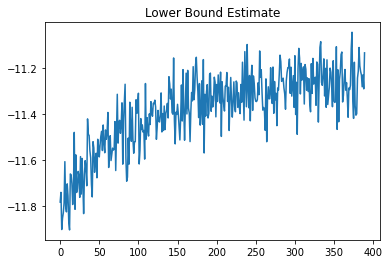

In [11]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot:title={'center':'Smoothed Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

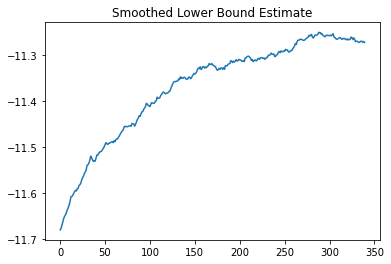

In [12]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [13]:
best_mu = best_lambda[0]

best_l = np.zeros((4, 4))
best_l[:, 0] = best_lambda[1][0:4]
best_l[1:4, 1] = best_lambda[1][4:7]
best_l[2:4, 2] = best_lambda[1][7:9]
best_l[3:4, 3] = best_lambda[1][9:10]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (np.exp(best_theta_tilde[:,1]) - 1) / (np.exp(best_theta_tilde[:,1]) + 1)
best_gamma = np.exp(best_theta_tilde[:,2])
best_delta = best_theta_tilde[:,3]
best_theta = np.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.56357575,  0.02387259,  1.03127264, -0.13388217])

Text(0.5, 1.0, 'Posterior density of alpha')

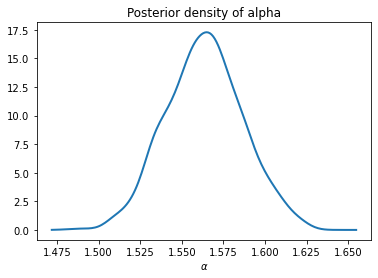

In [14]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.001)
kde = gaussian_kde(best_alpha)
y_plot = kde(x_plot)
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of beta')

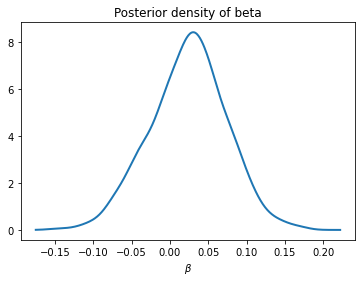

In [15]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.001)
kde = gaussian_kde(best_beta)
y_plot = kde(x_plot)
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

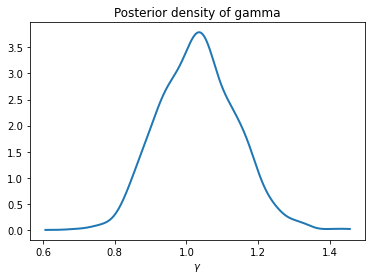

In [16]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
kde = gaussian_kde(best_gamma)
y_plot = kde(x_plot)
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

Text(0.5, 1.0, 'Posterior density of delta')

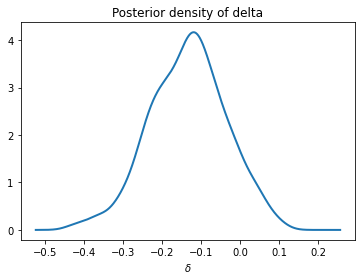

In [17]:
plt.figure()
x_plot = np.arange((np.mean(best_delta)-4*np.std(best_delta)), (np.mean(best_delta)+4*np.std(best_delta)), 0.001)
kde = gaussian_kde(best_delta)
y_plot = kde(x_plot)
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')